## AC Transit GTFS - Routes, Stops, Trips

This notebook calls the AC Transit API to collect route, stop, and trip information and locations.

**Links**: 
- [AC Transit API Documentation](https://api.actransit.org/transit/Help)
- [Using google.transit package to decode the protocol buffer returned by the API](https://github.com/MobilityData/gtfs-realtime-bindings/tree/master/python)

In [1]:
import pandas as pd
import numpy as np
import csv
import json
from datetime import datetime
import requests
from google.transit import gtfs_realtime_pb2

In [2]:
from config import *
BASE = "https://api.actransit.org/transit/"

## Routes and Directions

In [ ]:
# get routes from API
response = requests.get(BASE+"routes/?token="+KEY)
routes = response.json()

# initialize empty arrays for database
route_id = []
name = []
description = []
direction = []

# loop through routes
for i in routes:
    # get directions per route from API
    print("Now processing:{}".format(i['RouteId']))
    response = requests.get(BASE+"route/"+i['RouteId']+"/directions?token="+KEY)
    dir_response = response.json()
    
    # loop through directions
    for j in dir_response:
        route_id.append(i['RouteId'])
        name.append(i['Name'])
        description.append(i['Description'])
        direction.append(j)
    #end for j
#end for i

# save to dataframe
print("Saving to dataframe")
routes_dir_df = pd.DataFrame(
    {'RouteId': route_id,
     'Name': name,
     'Description': description,
     'Direction': direction
    })

# clean dataframe to only include routes with cardinal directions
print("Cleaning dataframe")
dir_keep = ['Northbound','Southbound', 'Eastbound','Westbound']
routes_dir_df = routes_dir_df[routes_dir_df.Direction.isin(dir_keep)]

print("DONE")

In [ ]:
# save to file
routes_dir_df.to_csv("../data/ACTransit_Routes.csv", index=False)

## Route Specific Directions (Stop Patterns)

In [ ]:
stop_ptrn_df = pd.DataFrame()

for r in routes_dir_df.RouteId:
    # call API
    print(f"Now processing: {r}")
    response = requests.get(BASE + "actrealtime/pattern?rt="+r+"&token="+KEY)
    patterns = response.json()
    
    # create empty lists to store data
    route_id = []
    rtdir = []
    lat = []
    lon = []
    stpid = []
    stpnm = []
    
    # collect relevant information
    for i in patterns['bustime-response']['ptr']:
        print(i['rtdir'])
        for j in i['pt']:
            try:
                if j['stpid']:
                    route_id.append(r)
                    rtdir.append(i['rtdir']) 
                    lat.append(j['lat'])
                    lon.append(j['lon'])
                    stpid.append(j['stpid'])
                    stpnm.append(j['stpnm'])
            except KeyError:
                continue
    
    # save to dataframe
    print("Saving to dataframe")
    temp_df = pd.DataFrame({'RouteId': route_id,
                            'rtdir': rtdir,
                            'lat': lat,
                            'lon': lon,
                            'stpid': stpid,
                            'stpnm': stpnm})
    stop_ptrn_df = stop_ptrn_df.append(temp_df, ignore_index=True)
    print("- - - -")

print("DONE")

In [ ]:
# save to file
stop_ptrn_df.to_csv("../data/ACTransit_StopPatterns.csv", index=False)

## Stops

In [ ]:
# call API
response = requests.get(BASE + "stops/?token="+KEY)
stops = response.json()

# initialize empty arrays for database
stop_id = []
stop_name = []
latitude = []
longitude = []
        

# loop through routes
for i in stops:
    stop_id.append(i['StopId'])
    stop_name.append(i['Name'])
    latitude.append(i['Latitude'])
    longitude.append(i['Longitude'])

# save to dataframe
print("Saving to dataframe")
stops_df = pd.DataFrame({'StopId': stop_id,
                         'StopName': stop_name,
                         'Latitude': latitude,
                         'Longitude': longitude})

In [ ]:
# save to file
stops_df.to_csv("../data/ACTransit_Stops.csv", index=False)

In [ ]:
stops_df.head()

## Trips

In [ ]:
trips_df = pd.DataFrame()

routes_dir_df = pd.read_csv("../data/ACTransit_Routes.csv")

for index, row in routes_dir_df.iterrows():
    
    # get row-specific data
    cur_rte = row.RouteId
    cur_dir = row.Direction
    
    # call API
    print(f"Now processing: {cur_rte}, {cur_dir}")
    try:
        response = requests.get(f"{BASE}route/{cur_rte}/trips?direction={cur_dir}&scheduleType=Weekday&token={KEY}")
        response.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
        continue
    
    # parse data into JSON
    trips = response.json()
    
    # create empty lists to store data
    trip_id = []
    start_time = []
    
    # collect relevant information
    for i in trips:
        trip_id.append(i['TripId']) 
        start_time.append(i['StartTime'])
    
    # save to dataframe
    print("Saving to dataframe")
    temp_df = pd.DataFrame({'RouteId': [cur_rte]*len(trips),
                            'Direction': [cur_dir]*len(trips),
                            'TripId': trip_id,
                            'StartTime': start_time})
    trips_df = trips_df.append(temp_df, ignore_index=True)
    print("- - - -")

print("DONE")

In [ ]:
# save to file
trips_df.to_csv("../data/ACTransit_Trips.csv", index=False)

In [ ]:
trips_df.head()

## Mapping Saved GTFS Data

In [3]:
import matplotlib.pyplot as plt
import geopandas as gpd
import folium

In [4]:
# import GTFS stops from .CSV file
stop_patterns_df = pd.read_csv("../data/ACTransit_StopPatterns.csv")

# convert dataframe to geodataframe
stop_patterns_gdf = gpd.GeoDataFrame(stop_patterns_df, 
                                     geometry=gpd.points_from_xy(stop_patterns_df.lon, stop_patterns_df.lat))

In [5]:
# Map stops along a specific route

# select route and create list of lat/lon coordinates to map
viz_route_name = "51B"
route_df = stop_patterns_df[stop_patterns_df.RouteId==viz_route_name].copy().reset_index(drop=True)
locations = route_df[['lat', 'lon']]
locationlist = locations.values.tolist()

# create folium map
map = folium.Map(location=[37.8, -122.2], tiles='CartoDB positron', zoom_start=12)

# create a marker for each stop in locationlist
for point in range(0, len(locationlist)):
    folium.Marker(
        locationlist[point], 
        popup=folium.Popup(
            "Route: " + route_df['RouteId'][point] + "\n" + 
            "Direction: " + route_df['rtdir'][point] + "\n" + 
            "Stop: " + route_df['stpnm'][point]
        )
    ).add_to(map)
    
# display map
map

In [6]:
# import coastline shapefile
outlines = gpd.read_file('zip://../data/cb_2016_us_state_500k.zip')

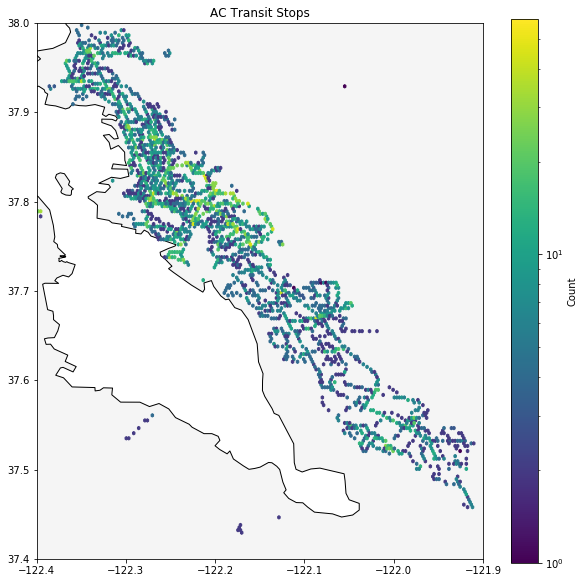

In [7]:
# plot static hexbin heatmap map of bus stops

fig, ax = plt.subplots(figsize=(10,10))

# Plot coastline using GeoPandas
outlines.plot(ax=ax, color='whitesmoke', edgecolor='black')

# Plot hexbins of bus stops using Matplotlib
hb = plt.hexbin(stop_patterns_df.lon, stop_patterns_df.lat, bins='log', mincnt=1, gridsize=180)

# Add a key
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Count')

# Title and bounds
ax.set_title('AC Transit Stops')
ax.set_xlim((-122.4, -121.9))
ax.set_ylim((37.4, 38.0))

plt.show()